This project requires Python 3.7 or above:

In [113]:
import sys

assert sys.version_info >= (3, 7)

## Problem Statement

Welcome to Machine Learning Housing Corp.! Your task is to <font color = 'red'>predict median house</font> values in Californian districts, given a number of features from these districts.

Use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them “districts” for short.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Get Data

In [114]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### Take a Quick Look at the Data Structure

In [115]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [116]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<font color='blue'>
    <p> There are 20,640 instances in the dataset<p>   
   <p><b>Total_bedrooms</b> attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature </p>
    <p>All attributes are numerical, except the <b>ocean_proximity</b></p> (looking at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute)
    <p></p>
</font>
    

In [117]:
housing["ocean_proximity"].value_counts()

# find out what categories exist and how many districts belong to each category by using the value_counts() method

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [118]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640). <p>The std row shows the standard deviation, which measures how dispersed the values are.⁠</p>
<p>The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall.</p><p> For example, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or first quartile), the median, and the 75th percentile (or third quartile).</p>

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. <p>A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). <p>You can either plot this one attribute at a time, or you can call the hist() method on the whole dataset (as shown in the following code example), and it will plot a histogram for each numerical attribute 

In [119]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

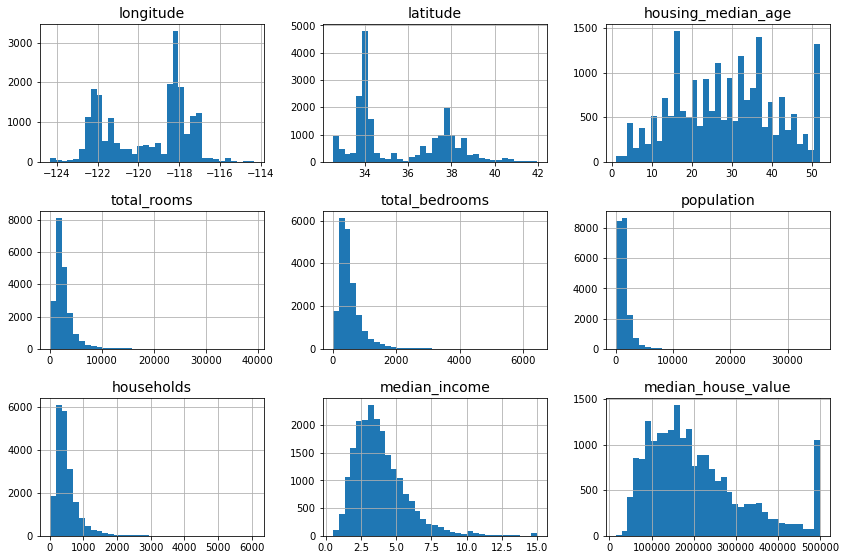

In [120]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=35, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

The median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.



<p>
The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

Collect proper labels for the districts whose labels were capped.

Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.

Finally, many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more symmetrical and bell-shaped distributions.

## Creating Test Set

### Implementation 1

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [121]:
import numpy as np

np.random.seed(42)

In [122]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42)) before calling np.random.permutation() so that it always generates the same shuffled indices.

In [123]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [124]:
len(test_set)

4128

### Implementation 2 from Scikit-Learn


Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. <p>The simplest function is train_test_split(), which does pretty much the same thing as the function shuffle_and_split_data() we defined earlier, with a couple of additional features. <p>First, there is a random_state parameter that allows you to set the random generator seed. Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [125]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)  # Same as above

### Implementation 3 using Hash


To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier).<p> For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value.<p> This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [126]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [127]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so

In [128]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [129]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929909


If you prefer simulations over maths, here's how you could get roughly the same result:

In [130]:
# extra code – shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. <p> You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. <p>Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely (back in Figure ): most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000),but some median incomes go far beyond 6. <p>It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased.<p><p>This means that you should not have too many strata, and each stratum should be large enough.

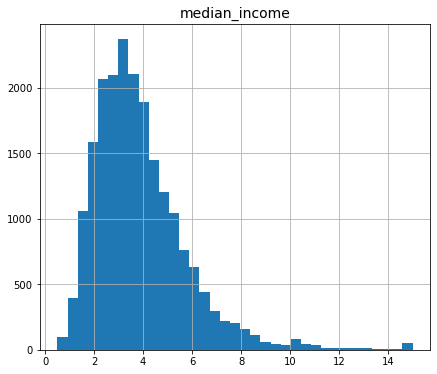

In [131]:
plt.title("median_income")

housing['median_income'].hist(bins=35, figsize=(7, 6))
plt.show()

The following code uses the <b>pd.cut()</b> function to create an income category attribute with five categories <p> (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [132]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=['0 - 1.4k', '1.5k - 2.9k','3.0k - 4.4k', '4.5k - 5.9k','6k - beyond'])

These income categories are represented in below

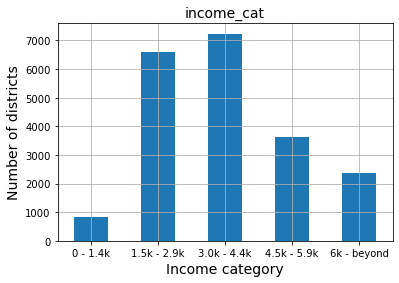

In [133]:
plt.title("income_cat")
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [134]:
housing["income_cat"].value_counts()

3.0k - 4.4k    7236
1.5k - 2.9k    6581
4.5k - 5.9k    3639
6k - beyond    2362
0 - 1.4k        822
Name: income_cat, dtype: int64

## Stratified Sampling

Following code generates 10 different stratified splits of the same dataset:

In [135]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.loc[train_index]
    strat_test_set_n = housing.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

For now, we can just use the first split:

In [136]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split (Another way):

In [137]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [138]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,6k - beyond
9985,-118.34,34.00,49.0,2863.0,411.0,1108.0,406.0,5.8993,313300.0,<1H OCEAN,4.5k - 5.9k
20434,-117.24,33.23,21.0,1718.0,308.0,1194.0,312.0,3.4359,150900.0,<1H OCEAN,3.0k - 4.4k
5940,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0k - 4.4k
13188,-122.42,37.65,39.0,4402.0,894.0,2941.0,887.0,3.8565,239800.0,NEAR OCEAN,3.0k - 4.4k
...,...,...,...,...,...,...,...,...,...,...,...
20514,-121.26,38.13,38.0,1419.0,411.0,1226.0,397.0,2.2188,68800.0,INLAND,1.5k - 2.9k
17785,-118.35,34.03,43.0,2122.0,524.0,1510.0,436.0,2.2273,123300.0,<1H OCEAN,1.5k - 2.9k
3495,-122.07,37.34,33.0,1208.0,198.0,495.0,216.0,5.4659,500001.0,<1H OCEAN,4.5k - 5.9k
11712,-119.72,34.41,35.0,1853.0,375.0,878.0,338.0,4.9044,335300.0,NEAR OCEAN,4.5k - 5.9k


In [139]:
len(strat_test_set)

4128

Looking at the income category proportions in the test set

In [140]:
strat_test_set["income_cat"].value_counts() /len(strat_test_set)

3.0k - 4.4k    0.350533
1.5k - 2.9k    0.318798
4.5k - 5.9k    0.176357
6k - beyond    0.114583
0 - 1.4k       0.039729
Name: income_cat, dtype: float64

In [141]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

The below table compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling.

As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.

In [142]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
0 - 1.4k,0.039826,0.039729,0.042393,6.447689,-0.243309
1.5k - 2.9k,0.318847,0.318798,0.307413,-3.586081,-0.015195
3.0k - 4.4k,0.350581,0.350533,0.345203,-1.533997,-0.013820
4.5k - 5.9k,0.176308,0.176357,0.184109,4.424292,0.027480
6k - beyond,0.114438,0.114583,0.120882,5.630821,0.127011


Now we won’t use the <b>income_cat</b> column anymore so we might as well drop it, reverting the data back to its original state:

In [143]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

C:\Users\jayac.SWEETHOME\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [144]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
9985,-118.34,34.00,49.0,2863.0,411.0,1108.0,406.0,5.8993,313300.0,<1H OCEAN
20434,-117.24,33.23,21.0,1718.0,308.0,1194.0,312.0,3.4359,150900.0,<1H OCEAN
5940,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
13188,-122.42,37.65,39.0,4402.0,894.0,2941.0,887.0,3.8565,239800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
20514,-121.26,38.13,38.0,1419.0,411.0,1226.0,397.0,2.2188,68800.0,INLAND
17785,-118.35,34.03,43.0,2122.0,524.0,1510.0,436.0,2.2273,123300.0,<1H OCEAN
3495,-122.07,37.34,33.0,1208.0,198.0,495.0,216.0,5.4659,500001.0,<1H OCEAN
11712,-119.72,34.41,35.0,1853.0,375.0,878.0,338.0,4.9044,335300.0,NEAR OCEAN


## Discover and Visualize the Data to Gain Insights

In [145]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

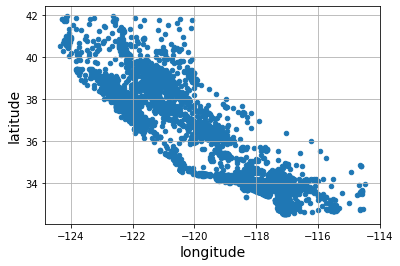

In [146]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.2 makes it much easier to visualize the places where there is a high density of data points

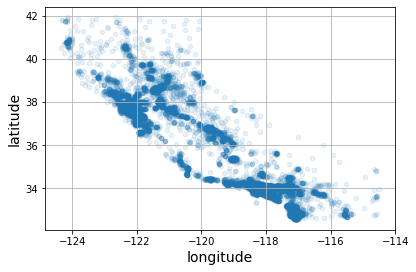

In [147]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)
save_fig("better_visualization_plot")



Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Our brains are very good at spotting patterns in pictures, but you may need to play around with visualization parameters to make the patterns stand out.

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

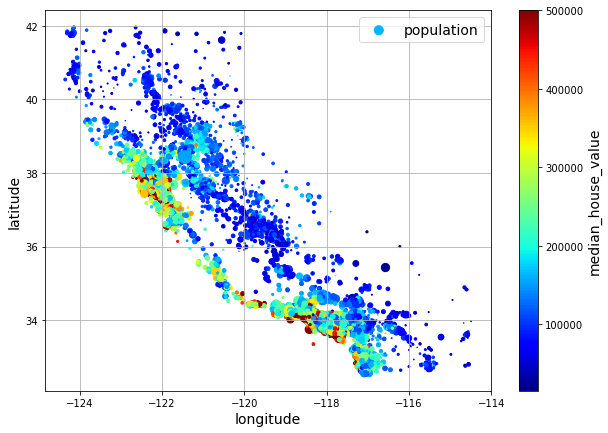

In [148]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

<font color = 'red'>The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed </font>(see: https://github.com/pandas-dev/pandas/issues/10611).

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

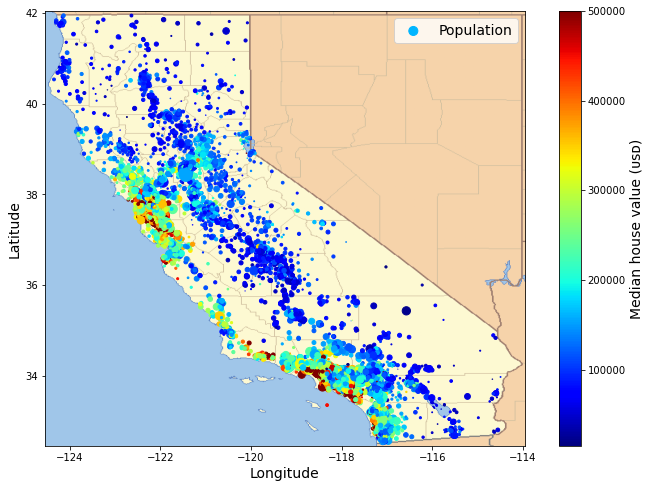

In [149]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method:

In [150]:
corr_matrix = housing.corr()

In [151]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924212,-0.102739,0.044445,0.068108,0.104169,0.054163,-0.016410,-0.050813
latitude,-0.924212,1.000000,0.005523,-0.036661,-0.066316,-0.115642,-0.071536,-0.078217,-0.139603
housing_median_age,-0.102739,0.005523,1.000000,-0.361661,-0.317891,-0.301755,-0.299973,-0.127368,0.102016
total_rooms,0.044445,-0.036661,-0.361661,1.000000,0.930066,0.863907,0.916126,0.197908,0.137549
total_bedrooms,0.068108,-0.066316,-0.317891,0.930066,1.000000,0.886170,0.978819,-0.005894,0.054707
population,0.104169,-0.115642,-0.301755,0.863907,0.886170,1.000000,0.916217,0.004361,-0.020134
households,0.054163,-0.071536,-0.299973,0.916126,0.978819,0.916217,1.000000,0.013772,0.071490
median_income,-0.016410,-0.078217,-0.127368,0.197908,-0.005894,0.004361,0.013772,1.000000,0.688390
median_house_value,-0.050813,-0.139603,0.102016,0.137549,0.054707,-0.020134,0.071490,0.688390,1.000000


Now let’s look at how much each attribute correlates with the median house value:

In [152]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688390
total_rooms           0.137549
housing_median_age    0.102016
households            0.071490
total_bedrooms        0.054707
population           -0.020134
longitude            -0.050813
latitude             -0.139603
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1.

When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. 

When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Finally, coefficients close to 0 mean that there is no linear correlation.

Another way to check for correlation between attributes is to use the Pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so let’s just focus on a few promising attributes that seem most correlated with the median housing value 

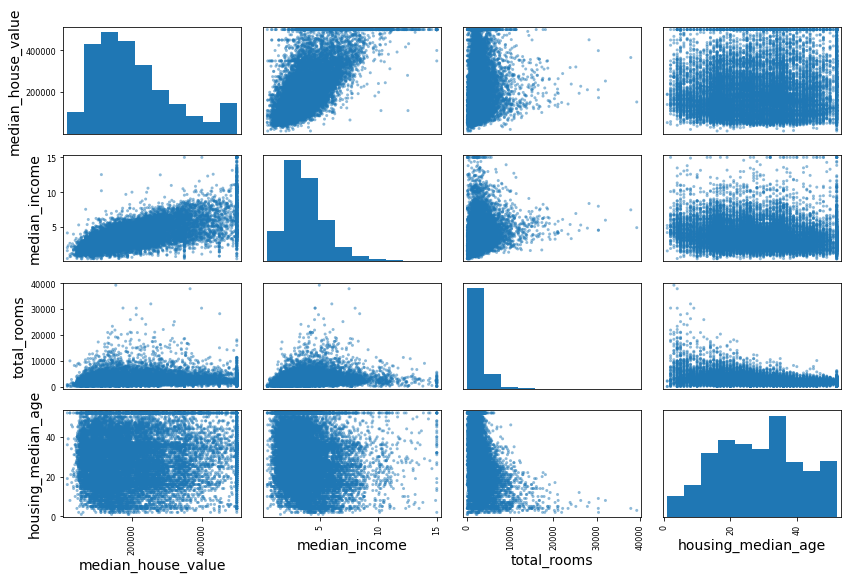

In [153]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

The main diagonal would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute (other options are available; see Pandas’ documentation for more details).

Looking at the correlation scatterplots, it seems like the most promising attribute to predict the median house value is the median income, so let’s zoom in on their scatterplot 

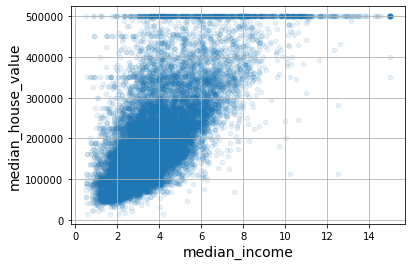

In [154]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

This plot reveals a few things. 

First, the correlation is indeed quite strong; you can clearly see the upward trend, and the points are not too dispersed. 

Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. 

But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. 

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

## Experimenting with Attribute Combinations


The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [155]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [156]:
housing[['population','households','total_rooms','total_bedrooms','rooms_per_house','bedrooms_ratio','people_per_house']]

,population,households,total_rooms,total_bedrooms,rooms_per_house,bedrooms_ratio,people_per_house
17950,2258.0,594.0,1925.0,597.0,3.240741,0.310130,3.801347
19445,1282.0,516.0,3623.0,528.0,7.021318,0.145736,2.484496
15413,526.0,132.0,657.0,147.0,4.977273,0.223744,3.984848
4371,339.0,140.0,736.0,148.0,5.257143,0.201087,2.421429
2921,828.0,283.0,2143.0,299.0,7.572438,0.139524,2.925795
...,...,...,...,...,...,...,...
5215,16305.0,5358.0,39320.0,6210.0,7.338559,0.157935,3.043113
12228,253.0,137.0,1167.0,370.0,8.518248,0.317052,1.846715
13741,553.0,230.0,1554.0,242.0,6.756522,0.155727,2.404348
10730,321.0,103.0,574.0,103.0,5.572816,0.179443,3.116505


And now let’s look at the correlation matrix again:

In [157]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688390
rooms_per_house       0.143695
total_rooms           0.137549
housing_median_age    0.102016
households            0.071490
total_bedrooms        0.054707
population           -0.020134
people_per_house     -0.038237
longitude            -0.050813
latitude             -0.139603
bedrooms_ratio       -0.256452
Name: median_house_value, dtype: float64

Hey, not bad! The new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. 

Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

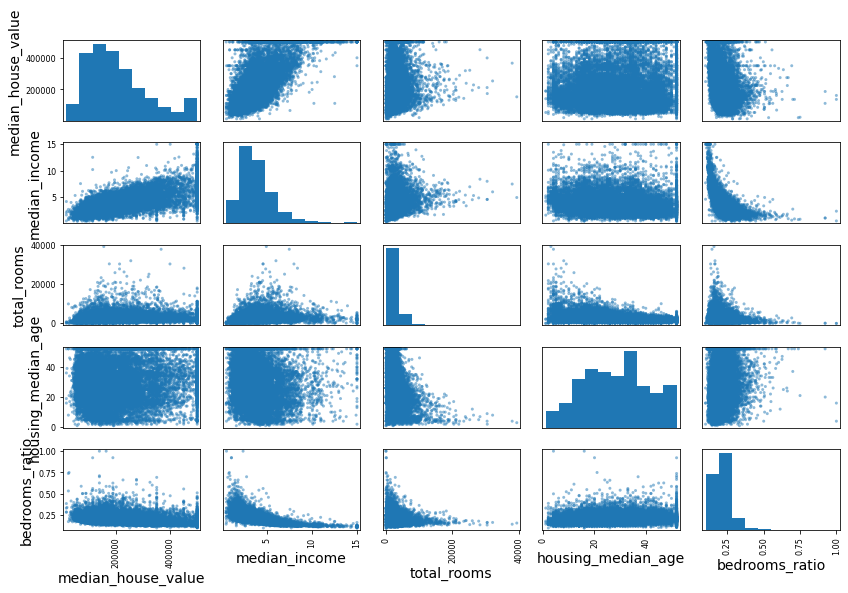

In [158]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age","bedrooms_ratio"]

scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

## Prepare the Data for Machine Learning Algorithms

Let’s also separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):

In [159]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [160]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17950,-118.15,34.16,52.0,1925.0,597.0,2258.0,594.0,1.6921,162500.0,<1H OCEAN
19445,-118.48,34.05,48.0,3623.0,528.0,1282.0,516.0,9.5221,500001.0,<1H OCEAN
15413,-118.25,33.93,42.0,657.0,147.0,526.0,132.0,2.5000,110200.0,<1H OCEAN
4371,-120.54,38.07,37.0,736.0,148.0,339.0,140.0,2.2875,79900.0,INLAND
2921,-117.32,33.17,18.0,2143.0,299.0,828.0,283.0,4.2383,239000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
5215,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND
12228,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,275000.0,NEAR BAY
13741,-121.47,39.49,17.0,1554.0,242.0,553.0,230.0,3.2174,91800.0,INLAND
10730,-117.68,34.04,27.0,574.0,103.0,321.0,103.0,3.9107,186500.0,INLAND


In [161]:
housing.isnull().any(axis=1)

17950    False
19445    False
15413    False
4371     False
2921     False
         ...  
5215     False
12228    False
13741    False
10730    False
15653    False
Length: 16512, dtype: bool

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

> Get rid of the corresponding districts.

> Get rid of the whole attribute.

> Set the missing values to some value (zero, the mean, the median, etc.). This is called imputation


You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

In [162]:
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

Let’s go for option 3 since it is the least destructive, but instead of the code above, we will use a handy Scikit-Learn class : <b>SimpleImputer.</b>

The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model. 

Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [163]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [164]:
housing.isnull().any(axis=1)

17950    False
19445    False
15413    False
4371     False
2921     False
         ...  
5215     False
12228    False
13741    False
10730    False
15653    False
Length: 16344, dtype: bool

In [165]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you need to create a copy of the data with only the numerical attributes (this will exclude the text attribute ocean_proximity):

In [166]:
housing_num = housing.select_dtypes(include=[np.number])

In [167]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16344 entries, 17950 to 15653
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16344 non-null  float64
 1   latitude            16344 non-null  float64
 2   housing_median_age  16344 non-null  float64
 3   total_rooms         16344 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16344 non-null  float64
 6   households          16344 non-null  float64
 7   median_income       16344 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


Now you can fit the imputer instance to the training data using the fit() method:

In [168]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. 

Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [169]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2125.5    ,  434.     ,
       1167.     ,  409.     ,    3.54035])

Check that this is the same as manually computing the median of each attribute:

In [170]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2125.5    ,  434.     ,
       1167.     ,  409.     ,    3.54035])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [171]:
X = imputer.transform(housing_num)

In [172]:
X

array([[-1.1815e+02,  3.4160e+01,  5.2000e+01, ...,  2.2580e+03,
         5.9400e+02,  1.6921e+00],
       [-1.1848e+02,  3.4050e+01,  4.8000e+01, ...,  1.2820e+03,
         5.1600e+02,  9.5221e+00],
       [-1.1825e+02,  3.3930e+01,  4.2000e+01, ...,  5.2600e+02,
         1.3200e+02,  2.5000e+00],
       ...,
       [-1.2147e+02,  3.9490e+01,  1.7000e+01, ...,  5.5300e+02,
         2.3000e+02,  3.2174e+00],
       [-1.1768e+02,  3.4040e+01,  2.7000e+01, ...,  3.2100e+02,
         1.0300e+02,  3.9107e+00],
       [-1.2236e+02,  3.8030e+01,  3.2000e+01, ...,  9.8100e+02,
         3.6900e+02,  4.3173e+00]])

In [173]:
imputer.feature_names_in_

AttributeError: 'SimpleImputer' object has no attribute 'feature_names_in_'

In [174]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [175]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [176]:
imputer.strategy

'median'

## Handling Text and Categorical Attributes